# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
from botocore.client import Config

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [39]:
# Загружаем данные из файлов .parquet
tracks_df = pd.read_parquet('tracks.parquet')
catalog_names_df = pd.read_parquet('catalog_names.parquet')
interactions_df = pd.read_parquet('interactions.parquet')

In [40]:
track_df = pd.DataFrame(tracks_df)
print(track_df.head(), "\n", track_df.shape)

   track_id                                             albums artists  \
0        26                                       [3, 2490753]    [16]   
1        38                                       [3, 2490753]    [16]   
2       135                                 [12, 214, 2490809]    [84]   
3       136                                 [12, 214, 2490809]    [84]   
4       138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...    [84]   

     genres  
0  [11, 21]  
1  [11, 21]  
2      [11]  
3      [11]  
4      [11]   
 (1000000, 4)


In [41]:
catalog_names_df = pd.DataFrame(catalog_names_df)
print(catalog_names_df.head(), "\n", catalog_names_df.shape)

   id   type               name
0   3  album    Taller Children
1  12  album  Wild Young Hearts
2  13  album      Lonesome Crow
3  17  album      Graffiti Soul
4  26  album     Blues Six Pack 
 (1812471, 3)


In [42]:
interactions_df = pd.DataFrame(interactions_df)
print(interactions_df.head(), "\n", interactions_df.shape)

   user_id  track_id  track_seq started_at
0        0     99262          1 2022-07-17
1        0    589498          2 2022-07-19
2        0    590262          3 2022-07-21
3        0    590303          4 2022-07-22
4        0    590692          5 2022-07-22 
 (222629898, 4)


In [43]:
track_df.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [44]:
catalog_names_df.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [45]:
interactions_df.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

<h3> Посмотрим track_df </h3>

In [46]:
genres_omissions = len(track_df[(track_df['genres'].str.len() == 0)])
artists_omissions = len(track_df[(track_df['artists'].str.len() == 0)])
albums_omissions = len(track_df[(track_df['albums'].str.len() == 0)])
print(f"Пропущено: жанров - {genres_omissions}, исполнителей - {artists_omissions}, альбомов - {albums_omissions}")

Пропущено: жанров - 3687, исполнителей - 15369, альбомов - 18


In [47]:
# Удалить строки, где в столбцах 'genres', 'artists' или 'albums' нет данных
track_df = track_df[(track_df['genres'].str.len() > 0) & 
                            (track_df['artists'].str.len() > 0) & 
                            (track_df['albums'].str.len() > 0)]

# Вывод количества оставшихся строк
print(f"Оставшиеся строки после удаления пропусков: {len(track_df)}, это {round((1-len(track_df)/1000000)*100,2)}%")

Оставшиеся строки после удаления пропусков: 980977, это 1.9%


<h3> Посмотрим catalog_names_df </h3>

In [48]:
catalog_names_df

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack
...,...,...,...
1812466,101478482,track,На лицо
1812467,101490148,track,Без капли мысли
1812468,101493057,track,SKITTLES
1812469,101495927,track,Москва


In [49]:
catalog_names_df.describe

<bound method NDFrame.describe of                 id   type               name
0                3  album    Taller Children
1               12  album  Wild Young Hearts
2               13  album      Lonesome Crow
3               17  album      Graffiti Soul
4               26  album     Blues Six Pack
...            ...    ...                ...
1812466  101478482  track            На лицо
1812467  101490148  track    Без капли мысли
1812468  101493057  track           SKITTLES
1812469  101495927  track             Москва
1812470  101521819  track             Вокзал

[1812471 rows x 3 columns]>

In [50]:
print("\nКоличество пропущенных значений:")
print(catalog_names_df.isna().sum())


Количество пропущенных значений:
id      0
type    0
name    0
dtype: int64


In [51]:
catalog_names_df['id'].duplicated().sum()

35774

есть дубли

In [52]:
print("\nУникальные значения для столбца 'type':")
print(catalog_names_df['type'].unique())


Уникальные значения для столбца 'type':
['album' 'artist' 'genre' 'track']


In [53]:
print("\nУникальные значения для столбца 'name':")
print(catalog_names_df['name'].unique())


Уникальные значения для столбца 'name':
['Taller Children' 'Wild Young Hearts' 'Lonesome Crow' ... 'АУТО'
 'Аккаунт удалён' 'tendril']


In [54]:
# Найдем строки с дубликатами по столбцу 'id' и отсортируем их по 'id'
duplicates_by_id = catalog_names_df[catalog_names_df.duplicated(subset='id', keep=False)]
duplicates_by_id_sorted = duplicates_by_id.sort_values(by='id')

print(duplicates_by_id_sorted)

               id    type                                       name
812308          3   genre                                     rusrap
0               3   album                            Taller Children
812309          4   genre                                   postrock
658724          4  artist                               Kenny Dorham
658725          5  artist                                  Max Roach
...           ...     ...                                        ...
1141114  21321251   track                                Lady in Red
1141142  21327491   track                               Waiting Here
658146   21327491   album  Lay With Me The Ultimate Fantasy Playlist
658501   21388828   album                             Serata Sanremo
1141665  21388828   track                                      Devil

[70418 rows x 3 columns]


Разделим на разные таблицы 'album' 'artist' 'genre' 'track'

In [55]:
album = catalog_names_df[catalog_names_df['type'] == 'album']
album

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack
...,...,...,...
658719,21458141,album,The Lazy Singles
658720,21458207,album,Jackie Mittoo Anthology
658721,21458968,album,Master Composers: Johann Sebastian Bach
658722,21459622,album,Take the Money and Run


In [56]:
artist = catalog_names_df[catalog_names_df['type'] == 'artist']
artist

,id,type,name
658724,4,artist,Kenny Dorham
658725,5,artist,Max Roach
658726,7,artist,Francis Rossi
658727,9,artist,Status Quo
658728,12,artist,Phil Everly
...,...,...,...
812300,16093680,artist,Los Tiburones
812301,16097398,artist,AMELI
812302,16098445,artist,2GANGSTA
812303,16099125,artist,Daria


In [57]:
genre = catalog_names_df[catalog_names_df['type'] == 'genre']
genre

,id,type,name
812305,0,genre,all
812306,1,genre,eastern
812307,2,genre,rusrock
812308,3,genre,rusrap
812309,4,genre,postrock
...,...,...,...
812466,1182,genre,balkan
812467,1197,genre,experimental
812468,1370,genre,europop
812469,1484,genre,meditation


In [59]:
genre.to_parquet('genres.parquet')

In [21]:
track = catalog_names_df[catalog_names_df['type'] == 'track']
track

,id,type,name
812471,26,track,Complimentary Me
812472,38,track,Momma's Boy
812473,135,track,Atticus
812474,136,track,24 Hours
812475,138,track,Don't Upset The Rhythm (Go Baby Go)
...,...,...,...
1812466,101478482,track,На лицо
1812467,101490148,track,Без капли мысли
1812468,101493057,track,SKITTLES
1812469,101495927,track,Москва


In [22]:
track[(track['name']=='-') | (track['name']=='!') | (track['name'].isna()) | (track['name']=='')]

,id,type,name
925200,1710520,track,!
1256428,31015987,track,-
1397711,40377624,track,!
1490613,49256430,track,-
1555859,56098412,track,!
1555860,56098413,track,!


In [23]:
len(track['name'].duplicated())

1000000

In [24]:
album[(album['name']=='-') | (album['name']=='!') | (album['name'].isna()) | (album['name']=='')]

,id,type,name
131744,2081150,album,!
135571,2154090,album,!
425113,8276982,album,!
425114,8276983,album,!
425241,8287692,album,!
425243,8287712,album,!
427432,8379799,album,!
427433,8379800,album,!


In [25]:
artist.dtypes

id       int64
type    object
name    object
dtype: object

In [26]:
artist[(artist['name']=='-') | (artist['name']=='!') | (artist['name'].isna()) | (artist['name']=='')]

,id,type,name
786980,7709071,artist,!


In [27]:
artist[artist.duplicated(subset='name', keep=False)].sort_values(by='name')

,id,type,name
789830,8159030,artist,104
765915,5489695,artist,104
809426,12579396,artist,163ONMYNECK
782986,7194299,artist,163ONMYNECK
808052,11811861,artist,22
...,...,...,...
756150,4766343,artist,Юрий Антонов
716203,1537249,artist,Ярослава
800906,9830980,artist,Ярослава
799956,9642096,artist,эхо


In [28]:
genre[(genre['name']=='-') | (genre['name']=='!') | (genre['name'].isna()) | (genre['name']=='')]

,id,type,name


<h3> Посмотрим interactions_df </h3>

In [29]:
interactions_df.dtypes

user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

In [30]:
print(interactions_df['started_at'].min(), interactions_df['started_at'].max())

2022-01-01 00:00:00 2022-12-31 00:00:00


In [31]:
# удалим нулевых пользователей
interactions_df = interactions_df[interactions_df['user_id'] != 0].reset_index(drop=True)

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

В таблице tracks_df есть пропуски: Пропущено: жанров - 3687, исполнителей - 15369, альбомов - 18
1 млн треков - эту проблему сразу устранили

В таблице catalog_names_df id не уникальные, поэтому для удобстава разбивает на отдельные таблицы справочники альбом, исполнитель, жанр, трек.
Есть альбомы, треки и исполнители без указанного name, вместо name '-' или '!'
в артист есть дубли - 4192 шт

большая таблица взаимодействий interactions_df, за 22год

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

<Axes: >

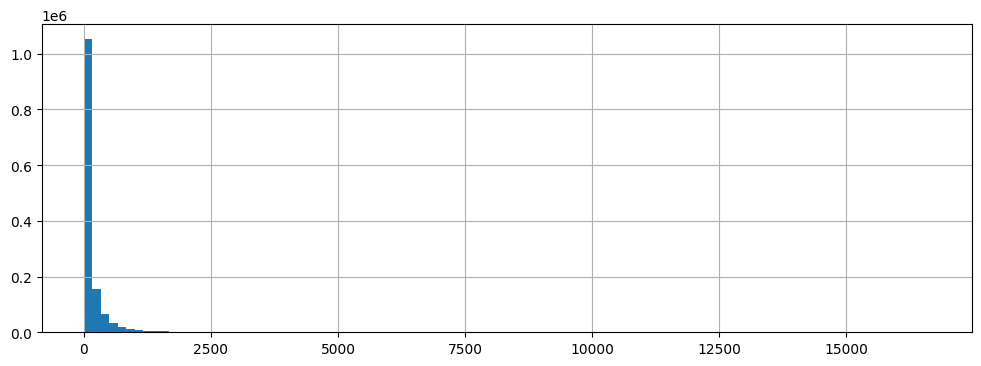

In [36]:
interactions_df.groupby("user_id").agg(a=("track_id", "count"))['a'].hist(bins=100, figsize=(12, 4))

<Axes: >

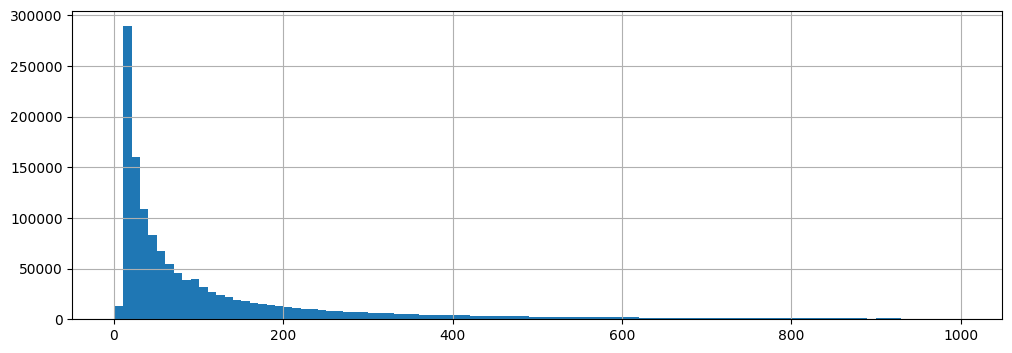

In [39]:
interactions_df.groupby("user_id").agg(a=("track_id", "count")).query('a < 1000')['a'].hist(bins=100, figsize=(12, 4))

Наиболее популярные треки

In [46]:
# Группируем по 'track_id' и считаем количество прослушиваний
track_popularity = interactions_df.groupby('track_id').size().reset_index(name='listen_count')

# Сортируем по количеству прослушиваний (по убыванию)
top_tracks = track_popularity.sort_values(by='listen_count', ascending=False)

merged_df = pd.merge(top_tracks, track, left_on='track_id', right_on='id', how='left')
merged_df = merged_df[['track_id','name','listen_count']]
merged_df.head()

,track_id,name,listen_count
0,53404,Smells Like Teen Spirit,111062
1,33311009,Believer,106921
2,178529,Numb,101924
3,35505245,I Got Love,99490
4,65851540,Юность,86670


Наиболее популярные жанры

In [47]:
# Подсчитаем количество прослушиваний для каждого трека
track_counts = interactions_df['track_id'].value_counts()

# Подсчитаем количество прослушиваний для каждого жанра
genre_counts = {}

for track_id, count in track_counts.items():
    genres1 = tracks_df.loc[tracks_df['track_id'] == track_id, 'genres'].values
    if len(genres1) > 0:
        for genre_id in genres1[0]:
            if genre_id not in genre_counts:
                genre_counts[genre_id] = 0
            genre_counts[genre_id] += count

# Создаем DataFrame с подсчетом популярности жанров
genre_counts_df = pd.DataFrame(list(genre_counts.items()), columns=['id', 'count'])

# Объединяем с названием жанров
genre_popularity = genre_counts_df.merge(catalog_names_df, on='id', how='left')

# Сортируем и отображаем
genre_popularity = genre_popularity.sort_values(by='count', ascending=False)
print(genre_popularity[['name', 'count']])

                               name     count
10                              pop  55578305
9                               rap  37799813
4                           allrock  31092012
11                           ruspop  26626236
7                   Taller Children  25303687
..                              ...       ...
264           In A Perfect World...        54
265                  It All Depends        54
266                             NaN        30
267                    B Is For Bob        30
268  In Search Of The Peace Of Mind        30

[270 rows x 2 columns]


Треки, которые никто не прослушал

In [48]:
unlistened_tracks = tracks_df[~tracks_df['track_id'].isin(interactions_df['track_id'])]

unlistened_tracks

,track_id,albums,artists,genres


In [49]:
tracks_df

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]"
999996,101490148,[21403052],[9078726],"[11, 20]"
999997,101493057,[21403883],[11865715],"[44, 75]"
999998,101495927,[21404975],[4462686],"[3, 75]"


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [51]:
# Создаём словарь: ключ - значение
artist_dict = artist.set_index('id')['name'].to_dict()
album_dict = album.set_index('id')['name'].to_dict()
genre_dict = genre.set_index('id')['name'].to_dict()

In [52]:
# Замена неизвестных исполнителей в массиве
tracks_df['artists_names'] = tracks_df['artists'].apply(
    lambda x: [artist_dict.get(artist_id, 'неизвестно') for artist_id in x]
)

# Замена неизвестных альбомов в массиве
tracks_df['albums_names'] = tracks_df['albums'].apply(
    lambda x: [album_dict.get(album_id, 'неизвестно') for album_id in x]
)

# Замена неизвестных жанров в массиве
tracks_df['genres_names'] = tracks_df['genres'].apply(
    lambda x: [genre_dict.get(genre_id, 'неизвестно') for genre_id in x]
)


In [55]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
tracks_df['item_id'] = labelencoder.fit_transform(tracks_df['track_id'])

In [56]:
tracks_df

,track_id,albums,artists,genres,artists_names,albums_names,genres_names,item_id
0,26,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",0
1,38,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",1
2,135,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],2
3,136,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],3
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",[pop],4
...,...,...,...,...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]",[FLESH],[На лицо],"[rusrap, rap]",999995
999996,101490148,[21403052],[9078726],"[11, 20]",[Даня Милохин],[Без капли мысли],"[pop, ruspop]",999996
999997,101493057,[21403883],[11865715],"[44, 75]",[WhyBaby?],[SKITTLES],"[foreignrap, rap]",999997
999998,101495927,[21404975],[4462686],"[3, 75]",[Yanix],[Москва],"[rusrap, rap]",999998


In [57]:
# Удаляем строки с "неизвестно"
tracks_df = tracks_df[
    tracks_df['artists_names'].apply(lambda x: 'неизвестно' not in x) &
    tracks_df['albums_names'].apply(lambda x: 'неизвестно' not in x) &
    tracks_df['genres_names'].apply(lambda x: 'неизвестно' not in x)
]

In [58]:
tracks_df

,track_id,albums,artists,genres,artists_names,albums_names,genres_names,item_id
0,26,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",0
1,38,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",1
2,135,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],2
3,136,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],3
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",[pop],4
...,...,...,...,...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]",[FLESH],[На лицо],"[rusrap, rap]",999995
999996,101490148,[21403052],[9078726],"[11, 20]",[Даня Милохин],[Без капли мысли],"[pop, ruspop]",999996
999997,101493057,[21403883],[11865715],"[44, 75]",[WhyBaby?],[SKITTLES],"[foreignrap, rap]",999997
999998,101495927,[21404975],[4462686],"[3, 75]",[Yanix],[Москва],"[rusrap, rap]",999998


In [59]:
interactions_df['item_id'] = labelencoder.transform(interactions_df['track_id'])

In [61]:
interactions_df

,user_id,track_id,track_seq,started_at,item_id
0,1,24417,1,2022-06-11,4345
1,1,108208,2,2022-06-13,18060
2,1,108209,3,2022-06-13,18061
3,1,592642,4,2022-06-15,61771
4,1,628687,5,2022-06-15,64517
...,...,...,...,...,...
222629867,1374582,95514767,288,2022-12-29,988273
222629868,1374582,97220301,289,2022-12-29,992765
222629869,1374582,97241171,290,2022-12-29,992848
222629870,1374582,98542641,291,2022-12-29,995791


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [62]:
# Создаем директорию, если она не существует
output_dir = 'recsys/data'
os.makedirs(output_dir, exist_ok=True)  # exist_ok=True позволяет не выбрасывать ошибку, если директория уже существует

# Теперь сохраняем файлы
tracks_df.to_parquet(f'{output_dir}/items.parquet')
interactions_df.to_parquet(f'{output_dir}/events.parquet')

In [63]:
# Загружаем переменные окружения из .env
load_dotenv()

s3_bucket = os.getenv('s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

# Настройка сессии с указанием региона и endpoint для Яндекс S3
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='ru-central1'
)

s3 = session.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', s3={'addressing_style': 'path'})
)

bucket_name = s3_bucket

# Пути к файлам для загрузки
output_dir = "recsys/data"  
items_file_path = f"{output_dir}/items.parquet"
events_file_path = f"{output_dir}/events.parquet"

try:
    # Проверка успешного подключения
    response = s3.get_bucket_location(Bucket=bucket_name)
    print("Подключение успешно. Креды работают.")
    
    # Загрузка файлов на S3
    s3.upload_file(items_file_path, bucket_name, 'recsys/data/items.parquet')
    s3.upload_file(events_file_path, bucket_name, 'recsys/data/events.parquet')
    print("Файлы успешно загружены на S3.")

except Exception as e:
    print("Ошибка подключения или загрузки файлов:", e)

Подключение успешно. Креды работают.
Файлы успешно загружены на S3.


In [64]:
result = s3.list_objects_v2(Bucket=bucket_name, Prefix='recsys/data/')
    
    # Проверяем, есть ли объекты в бакете по заданному префиксу
if 'Contents' in result:
    print("Содержимое бакета:")
    for obj in result['Contents']:
        print(f"- {obj['Key']} (Last Modified: {obj['LastModified']})")
else:
    print("Нет объектов в указанной директории.")

Содержимое бакета:
- recsys/data/events.parquet (Last Modified: 2025-04-06 18:34:58.739000+00:00)
- recsys/data/items.parquet (Last Modified: 2025-04-06 18:34:50.993000+00:00)


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [65]:
# Очистить все переменные и объекты в текущем пространстве имен
%reset -f

Перезапускаем ядро в интерфейсе далее начинаем с 3го этапа

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
from botocore.client import Config
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Загружаем данные из файлов .parquet
items = pd.read_parquet('recsys/data/items.parquet')
events = pd.read_parquet('recsys/data/events.parquet')
items=pd.DataFrame(items)
events=pd.DataFrame(events)

In [3]:
items

,track_id,albums,artists,genres,artists_names,albums_names,genres_names,item_id
0,26,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",0
1,38,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",1
2,135,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],2
3,136,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],3
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",[pop],4
...,...,...,...,...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]",[FLESH],[На лицо],"[rusrap, rap]",999995
999996,101490148,[21403052],[9078726],"[11, 20]",[Даня Милохин],[Без капли мысли],"[pop, ruspop]",999996
999997,101493057,[21403883],[11865715],"[44, 75]",[WhyBaby?],[SKITTLES],"[foreignrap, rap]",999997
999998,101495927,[21404975],[4462686],"[3, 75]",[Yanix],[Москва],"[rusrap, rap]",999998


In [4]:
events

,user_id,track_id,track_seq,started_at,item_id
0,1,24417,1,2022-06-11,4345
1,1,108208,2,2022-06-13,18060
2,1,108209,3,2022-06-13,18061
3,1,592642,4,2022-06-15,61771
4,1,628687,5,2022-06-15,64517
...,...,...,...,...,...
222629867,1374582,95514767,288,2022-12-29,988273
222629868,1374582,97220301,289,2022-12-29,992765
222629869,1374582,97241171,290,2022-12-29,992848
222629870,1374582,98542641,291,2022-12-29,995791


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [5]:
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events['started_at'] < train_test_global_time_split_date

events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

common_users = users_train[users_train.isin(users_test)]

print(f"Кол-во строк в events_train {len(events_train)}")
print(f"Кол-во строк в events_test {len(events_test)}")
print(f"Кол-во пользователей в train {len(users_train)}")
print(f"Кол-во пользователей в test {len(users_test)}")
print(f"Кол-во пользователей, которые есть и в train, и в test {len(common_users)}")

Кол-во строк в events_train 208731226
Кол-во строк в events_test 13898646
Кол-во пользователей в train 1342565
Кол-во пользователей в test 783525
Кол-во пользователей, которые есть и в train, и в test 752870


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [6]:
# Холодные пользователи — те, кто есть в test, но отсутствуют в train
cold_users = users_test[~users_test.isin(users_train)]
# Выводим количество холодных пользователей
print(len(cold_users))

30655


In [7]:
top_pop_start_date = pd.to_datetime("2022-11-16").date()

item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["item_id"]).agg(users=("user_id", "nunique")).reset_index()

# нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу
scaler = MinMaxScaler()
item_popularity[["popularity_score"]] = scaler.fit_transform(
    item_popularity[["users"]])

# сортируем по убыванию popularity_score
item_popularity = item_popularity.sort_values(by='popularity_score',ascending=False)

In [8]:
item_popularity

,item_id,users,popularity_score
771260,940964,23606,1.000000
614108,779281,23093,0.978267
766295,935913,22918,0.970854
662069,829320,22682,0.960856
747797,917171,22401,0.948951
...,...,...,...
663770,831079,1,0.000000
663771,831080,1,0.000000
663772,831081,1,0.000000
663690,830996,1,0.000000


In [9]:
items = items.merge(item_popularity.drop(['users'], axis=1), how='left', on='item_id')

In [10]:
items

,track_id,albums,artists,genres,artists_names,albums_names,genres_names,item_id,popularity_score
0,26,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",0,NaN
1,38,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",1,NaN
2,135,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],2,NaN
3,136,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],3,NaN
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",[pop],4,NaN
...,...,...,...,...,...,...,...,...,...
951650,101478482,[21399811],[5540395],"[3, 75]",[FLESH],[На лицо],"[rusrap, rap]",999995,0.000000
951651,101490148,[21403052],[9078726],"[11, 20]",[Даня Милохин],[Без капли мысли],"[pop, ruspop]",999996,0.000678
951652,101493057,[21403883],[11865715],"[44, 75]",[WhyBaby?],[SKITTLES],"[foreignrap, rap]",999997,0.000042
951653,101495927,[21404975],[4462686],"[3, 75]",[Yanix],[Москва],"[rusrap, rap]",999998,0.000212


In [11]:
# топ 100 популярных треков
top_100_popular_tracks = item_popularity.head(100)
top_100_popular_tracks = top_100_popular_tracks.merge(items[['item_id', 'artists_names', 'albums_names', 'genres_names']], on="item_id")

top_100_popular_tracks

,item_id,users,popularity_score,artists_names,albums_names,genres_names
0,940964,23606,1.000000,[HammAli & Navai],[Птичка],"[pop, ruspop]"
1,779281,23093,0.978267,[The Weeknd],"[Blinding Lights, After Hours, After Hours, Af...",[rnb]
2,935913,22918,0.970854,[Galibri & Mavik],[Федерико Феллини],"[pop, ruspop]"
3,829320,22682,0.960856,[Dabro],[Юность],"[pop, ruspop]"
4,917171,22401,0.948951,[Minelli],"[Rampampam, Rampampam]",[dance]
...,...,...,...,...,...,...
95,935835,9528,0.403601,"[Masked Wolf, Alok]","[Astronaut In The Ocean, Teamwrk Dance - Best ...",[dance]
96,751344,9455,0.400508,"[FILV, Edmofo]","[Clandestina, Fresh Dance, Yeni Dünya Special ...",[dance]
97,736286,9443,0.400000,[Dabro remix],[Улетай на крыльях ветра],"[rusrap, rap]"
98,579622,9425,0.399237,[Zivert],[Сияй],"[pop, ruspop]"


In [12]:
# Создаем директорию, если она не существует
output_dir = 'recsys/recommendations'
os.makedirs(output_dir, exist_ok=True)  # exist_ok=True позволяет не выбрасывать ошибку, если директория уже существует

# Теперь сохраняем файлы
top_100_popular_tracks.to_parquet(f'{output_dir}/top_popular.parquet', engine='pyarrow')

In [13]:
cold_users = set(cold_users)

In [14]:
cold_users_events_with_recs = events_test.query("user_id in @cold_users").merge(top_100_popular_tracks, on="item_id", how="left")

In [15]:
cold_user_items_no_pop_idx = cold_users_events_with_recs["popularity_score"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_pop_idx] \
    [["item_id", "popularity_score"]] 

In [16]:
cold_user_recs

,item_id,popularity_score
56,757669,0.675916
100,728976,0.531794
115,692312,0.466215
166,825152,0.426901
168,899769,0.397162
...,...,...
1102333,668078,0.557848
1102335,696106,0.747087
1102339,731961,0.659691
1102346,863034,0.414785


In [17]:
# Загружаем переменные окружения из .env
load_dotenv()

s3_bucket = os.getenv('s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

# Настройка сессии с указанием региона и endpoint для Яндекс S3
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='ru-central1'
)

s3 = session.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', s3={'addressing_style': 'path'})
)

bucket_name = s3_bucket

# Пути к файлам для загрузки
output_dir = "recsys/recommendations"  
items_file_path = f"{output_dir}/top_popular.parquet"

try:
    # Проверка успешного подключения
    response = s3.get_bucket_location(Bucket=bucket_name)
    print("Подключение успешно. Креды работают.")
    
    # Загрузка файлов на S3
    s3.upload_file(items_file_path, bucket_name, 'recsys/recommendations/top_popular.parquet')
    print("Файлы успешно загружены на S3.")

except Exception as e:
    print("Ошибка подключения или загрузки файлов:", e)

Подключение успешно. Креды работают.
Файлы успешно загружены на S3.


# Персональные

Рассчитаем персональные рекомендации.

In [18]:
events_test = events_test.merge(items[['item_id', 'popularity_score']], how='left', on='item_id')
events_train = events_train.merge(items[['item_id', 'popularity_score']], how='left', on='item_id')

In [19]:
events_train = events_train.dropna()
events_test = events_test.dropna()
items = items.fillna(0)

In [20]:
print(events_train['popularity_score'].dtype)
print(events_test['popularity_score'].dtype)
print(items['popularity_score'].dtype)

float64
float64
float64


In [21]:
events_test.to_parquet('recsys/data/events_test.parquet')
events_train.to_parquet('recsys/data/events_train.parquet')
items.to_parquet('recsys/data/items.parquet')

In [1]:
# Очистить все переменные и объекты в текущем пространстве имен
%reset -f

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
from botocore.client import Config
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [43]:
# Загружаем данные из файлов .parquet
items = pd.read_parquet('recsys/data/items.parquet')
events = pd.read_parquet('recsys/data/events.parquet')
events_test = pd.read_parquet('recsys/data/events_test.parquet')
events_train = pd.read_parquet('recsys/data/events_train.parquet')
items=pd.DataFrame(items)
events=pd.DataFrame(events)
events_test=pd.DataFrame(events_test)
events_train=pd.DataFrame(events_train)

In [4]:
events_train = events_train.rename(columns={'popularity_score': 'rating'})
events_test = events_test.rename(columns={'popularity_score': 'rating'})
items = items.rename(columns={'popularity_score': 'rating'})

In [5]:
events_train['rating'] = events_train['rating'] * 5
events_test['rating'] = events_test['rating'] * 5
items['rating'] = items['rating'] * 5

In [6]:
events_train['rating'] = events_train['rating'].apply(round)
events_test['rating'] = events_test['rating'].apply(round)
items['rating'] = items['rating'].apply(round)

In [7]:
events_train['rating'] = events_train['rating'].astype(np.int8)
events_test['rating'] = events_test['rating'].astype(np.int8)
items['rating'] = items['rating'].astype(np.int8)

In [8]:
events_test.to_parquet('recsys/data/events_test.parquet')
events_train.to_parquet('recsys/data/events_train.parquet')
items.to_parquet('recsys/data/items.parquet')

<H2>ALS</H2>

In [5]:
# Очистить все переменные и объекты в текущем пространстве имен
%reset -f

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
from botocore.client import Config
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy
import sklearn.preprocessing
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
# Загружаем данные из файлов .parquet
items = pd.read_parquet('recsys/data/items.parquet')
events = pd.read_parquet('recsys/data/events.parquet')
events_test = pd.read_parquet('recsys/data/events_test.parquet')
events_train = pd.read_parquet('recsys/data/events_train.parquet')
items=pd.DataFrame(items)
events=pd.DataFrame(events)
events_test=pd.DataFrame(events_test)
events_train=pd.DataFrame(events_train)

In [3]:
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

In [4]:
# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

In [8]:
import sys

sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3

4.652125923894346

слетает ядро, попробуем уменьшить объем 

In [5]:
events_train = events_train[::10]

In [6]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8) 

создание и тренировка модели на разряженой матрице user_item_matrix_train

In [7]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=40, iterations=20, regularization=0.05, random_state=0, num_threads=4)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mle-user/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  5.00s/it]


Чтобы получить рекомендации для пользователя с помощью модели ALS, используем такую функцию:

In [8]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [9]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

In [10]:
user_ids_encoded = user_ids_encoded[::10]
print(len(user_ids_encoded))

137322


In [11]:
# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=100)

In [12]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [13]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("recsys/recommendations/personal_als.parquet")

In [14]:
als_recommendations

,user_id,item_id,score
0,1,935913,1.154886e-13
1,1,946020,5.323334e-14
2,1,731961,4.667209e-14
3,1,697841,4.226121e-14
4,1,848374,3.622915e-14
...,...,...,...
13732195,1374573,627168,8.602429e-03
13732196,1374573,769728,8.521857e-03
13732197,1374573,679938,8.450371e-03
13732198,1374573,732308,8.436943e-03


In [15]:
als_recommendations = (
    als_recommendations
    .merge(events_test[["user_id", "item_id", "rating"]]
               .rename(columns={"rating": "rating_test"}), 
           on=["user_id", "item_id"], how="left")
)

In [16]:
import sklearn.metrics

def compute_ndcg(rating: pd.Series, score: pd.Series, k):

    """ подсчёт ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов (по убыванию score) для оценки, остальные - отбрасываются
    """
    
    # если кол-во объектов меньше 2, то NDCG - не определена
    if len(rating) < 2:
        return np.nan

    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)

    return ndcg

In [17]:
rating_test_idx = ~als_recommendations["rating_test"].isnull()
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["score"], k=5))

In [18]:
print(ndcg_at_5_scores.mean())

0.9619311591251274


In [19]:
load_dotenv()

session = boto3.Session(
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
    region_name='ru-central1'
)

s3 = session.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', s3={'addressing_style': 'path'})
)

bucket_name = os.getenv('s3_bucket')
items_file_path = "recsys/recommendations/personal_als.parquet"

try:
    # Проверка успешного подключения
    s3.get_bucket_location(Bucket=bucket_name)
    print("Подключение успешно. Креды работают.")
    
    # Загрузка файла на S3
    s3.upload_file(items_file_path, bucket_name, 'recsys/recommendations/personal_als.parquet')
    print("Файл успешно загружен на S3.")
    
except Exception as e:
    print("Ошибка подключения или загрузки файла:", e)

Подключение успешно. Креды работают.
Файл успешно загружен на S3.


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [1]:
# Очистить все переменные и объекты в текущем пространстве имен
%reset -f

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
from botocore.client import Config
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy
import sklearn.preprocessing
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
items = pd.read_parquet('recsys/data/items.parquet')

In [4]:
items

,track_id,albums,artists,genres,artists_names,albums_names,genres_names,item_id,rating
0,26,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",0,0
1,38,"[3, 2490753]",[16],"[11, 21]",[Elizabeth & the Catapult],"[Taller Children, Taller Children]","[pop, folk]",1,0
2,135,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],2,0
3,136,"[12, 214, 2490809]",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[pop],3,0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],[Noisettes],"[Wild Young Hearts, Wild Young Hearts, Don't U...",[pop],4,0
...,...,...,...,...,...,...,...,...,...
951650,101478482,[21399811],[5540395],"[3, 75]",[FLESH],[На лицо],"[rusrap, rap]",999995,0
951651,101490148,[21403052],[9078726],"[11, 20]",[Даня Милохин],[Без капли мысли],"[pop, ruspop]",999996,0
951652,101493057,[21403883],[11865715],"[44, 75]",[WhyBaby?],[SKITTLES],"[foreignrap, rap]",999997,0
951653,101495927,[21404975],[4462686],"[3, 75]",[Yanix],[Москва],"[rusrap, rap]",999998,0


In [40]:
from collections import Counter

def get_genres(items):
    all_genres = []

    for _, row in items.iterrows():
        genres = row["genres_names"] 
        if genres is None:
            continue
        all_genres.extend(genres)      # добавляем все жанры в общий список

    genre_counter = Counter(all_genres)   # считаем, сколько раз встречается каждый жанр

    return pd.DataFrame(genre_counter.items(), columns=["name", "votes"])

In [41]:
genres = get_genres(items)
genres["score"] = genres["votes"] / genres["votes"].sum()
genres = genres.sort_values(by="score", ascending=False)

In [7]:
genres.to_parquet("genres.parquet")

In [8]:
genres

,name,votes,score
0,pop,166110,0.106819
19,rap,128206,0.082445
3,allrock,118464,0.076180
9,electronics,106491,0.068481
73,rusrap,65958,0.042415
...,...,...,...
117,asmr,45,0.000029
103,israelirock,44,0.000028
105,israelirap,32,0.000021
136,narrative,25,0.000016


In [42]:
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

def get_item2genre_matrix(genres, items):
    genre_to_index = genres.reset_index().set_index("name")["index"].to_dict()
    genre_to_votes = genres.set_index("name")["votes"].to_dict()

    data, rows, cols = [], [], []

    for item_idx, row in items.iterrows():
        genres_list = row.get("genres_names")
        if not len(genres_list):
            continue
        for genre in genres_list:
            data.append(genre_to_votes[genre])
            rows.append(item_idx)
            cols.append(genre_to_index[genre])

    matrix = csr_matrix((data, (rows, cols)), shape=(len(items), len(genres)))
    return normalize(matrix, norm='l1', axis=1)

In [43]:
all_items_genres_csr = get_item2genre_matrix(genres, items)

In [ ]:
user_id = 3
user_events = events_train.query("user_id == @user_id")[["item_id", "rating"]]
user_items = items[items["item_id"].isin(user_events["item_id"])].reset_index(drop=True)
user_items_genres_csr = get_item2genre_matrix(genres, user_items)

In [ ]:
user_ratings = user_events["rating"].to_numpy()
user_ratings = np.expand_dims(user_ratings, axis=1)
user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)
user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

In [ ]:
user_genres = genres.copy()
user_genres["score"] = np.ravel(user_genres_scores)
user_genres = user_genres[user_genres["score"] > 0].sort_values(by=["score"], ascending=False)
user_genres.head()

In [ ]:
similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)
similarity_scores = similarity_scores.flatten()

In [ ]:
k = 100
content_recs_df = pd.DataFrame(columns=["rec_track_id_enc","rec_score"])
top_k_indices = np.argsort(similarity_scores)[::-1].tolist()[:k]
top_k_scores = np.sort(similarity_scores)[::-1].tolist()[:k]
content_recs_df["rec_track_id_enc"] = top_k_indices
content_recs_df["rec_score"] = top_k_scores
content_recs_df

In [ ]:
selected_items = items[items["item_id"].isin(top_k_indices)]
selected_items[["track_id", "item_id", "artists_names", "genres_names"]].head()

In [ ]:
users_last_track = events_train.groupby("user_id").agg(track_seq=("track_seq", "max")).reset_index()
users_last_track = users_last_track.merge(events_train, on=["user_id", "track_seq"],how="left")[["user_id", "item_id", "track_seq"]]

In [ ]:
track_ids = list(users_last_track["item_id"].unique())

In [ ]:
from tqdm import tqdm
similar_items_df = []

for track in tqdm(track_ids):
    tr = items.query("item_id == @track")["item_id"].to_list()
    try: 
        tr = tr[0]
        similar_item = als_model.similar_items(tr, N=2)
        similar_item_id = similar_item[0].tolist()[1]
        similar_item_score = similar_item[1].tolist()[1]
        tr = items.query("item_id == @similar_item_id")["item_id"].to_list()[0]
        similar_items_df.append({"item_id": track,
                                "sim_track_id": tr,
                                "sim_track_score": round(similar_item_score,3)})
    except:
        pass

In [ ]:
similar_items_df = pd.DataFrame(similar_items_df)

In [ ]:
similar_items_df = similar_items_df.rename(columns={'item_is': 'item_id'})

In [ ]:
similar_items_df.head()

In [ ]:
similar_items_df = similar_items_df.set_index('item_id')

In [ ]:
similar_items_df.head()

In [42]:
users_last_track.head()

,user_id,item_id,track_seq
0,1,913825,31
1,2,188826,6
2,3,848375,32
3,4,938153,242
4,5,472891,68


In [47]:
similar = users_last_track.merge(similar_items_df, on="item_id", how="left")[["item_id", "user_id", "sim_track_id", "sim_track_score"]]
similar = similar.dropna()
similar["sim_track_id"] = similar["sim_track_id"].astype("int")
similar["sim_track_score"] = similar["sim_track_score"].astype("float")

In [48]:
similar.head()

,item_id,user_id,sim_track_id,sim_track_score
0,913825,1,755141,0.991
1,188826,2,642149,0.980
2,848375,3,0,0.000
3,938153,4,545260,0.993
4,472891,5,118730,0.990


In [49]:
similar.to_parquet("similar.parquet")

In [50]:
s3.upload_file("similar.parquet", bucket_name, 'recsys/recommendations/similar.parquet')

In [51]:
response = s3.list_objects_v2(Bucket=bucket_name)
# Проверяем, есть ли объекты в бакете
if 'Contents' in response:
    for obj in response['Contents'][-5:]:
        print(f"Имя объекта: {obj['Key']}, Размер: {obj['Size']} байт")
else:
    print("Бакет пуст или не существует.")

Имя объекта: recsys/data/events.parquet, Размер: 2001752959 байт
Имя объекта: recsys/data/items.parquet, Размер: 62625165 байт
Имя объекта: recsys/recommendations/personal_als.parquet, Размер: 107610401 байт
Имя объекта: recsys/recommendations/similar.parquet, Размер: 17600739 байт
Имя объекта: recsys/recommendations/top_popular.parquet, Размер: 25165 байт


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [13]:
# Очистить все переменные и объекты в текущем пространстве имен
%reset -f

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
from botocore.client import Config
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy
import sklearn.preprocessing
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
events_test = pd.read_parquet('recsys/data/events_test.parquet')

In [16]:
split_date_for_test = pd.to_datetime("2022-12-23")
split_date_for_test_idx = events_test["started_at"] < split_date_for_test
events_test_1 = events_test[split_date_for_test_idx].copy()
events_test_2 = events_test[~split_date_for_test_idx].copy()

In [17]:
als_recommendations = pd.read_parquet("recsys/recommendations/personal_als.parquet")

In [18]:
events_test_1["target"] = 1
candidates = als_recommendations.merge(events_test_1[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"], 
                              how="left")
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [19]:
# оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [20]:
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ])

In [21]:
events_train = pd.read_parquet('recsys/data/events_train.parquet')

In [22]:
events_inference = pd.concat([events_train, events_test_1])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

In [23]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = als_recommendations[als_recommendations["user_id"].isin(events_test_2["user_id"].drop_duplicates())]
print(candidates_to_rank.shape)

(6000600, 3)


In [24]:
candidates_to_rank.query("score > 0", inplace=True)

/tmp/ipykernel_2186/3779055581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_to_rank.query("score > 0", inplace=True)


In [25]:
candidates_to_rank.reset_index(drop=True, inplace=True)

In [26]:
candidates_to_rank.sort_values(by=['user_id', 'score'], ascending=False, inplace=True)
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id")["score"].cumcount() + 1

/tmp/ipykernel_2186/944051501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_to_rank.sort_values(by=['user_id', 'score'], ascending=False, inplace=True)
/tmp/ipykernel_2186/944051501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id")["score"].cumcount() + 1


In [27]:
candidates_to_rank.to_parquet("candidates_to_rank.parquet")

In [28]:
candidates_to_rank = pd.read_parquet("candidates_to_rank.parquet")

In [29]:
items = pd.read_parquet('recsys/data/items.parquet')

In [30]:
def get_user_features(events):
    user_features = events.groupby("user_id").agg(
        listening_days=("started_at", lambda x: (x.max()-x.min()).days),
        listened_tracks=("item_id", "nunique")
        )
    
    user_features["tracks_per_day"] = user_features["listened_tracks"] / user_features["listening_days"]
    
    return user_features

In [31]:
events_train = events_train[::10]

In [32]:
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

In [33]:
candidates_for_train.to_parquet('candidates_for_train_merge.parquet')

In [34]:
events_test = pd.read_parquet('recsys/data/events_test.parquet')

In [35]:
# оставим только тех пользователей, что есть в тесте, для экономии ресурсов
events_inference = pd.concat([events_train, events_test_1])
events_inference = events_inference[events_inference["user_id"].isin(events_test["user_id"].drop_duplicates())]

In [36]:
user_features_for_ranking = get_user_features(events_inference)

In [37]:
candidates_to_rank = candidates_to_rank.merge(user_features_for_ranking, on=["user_id"], how="left")

In [38]:
candidates_to_rank.to_parquet('candidates_to_rank_merge.parquet')

In [45]:
genre = pd.read_parquet("genres.parquet")

In [46]:
# определяем индексы топ-10 жанров и всех остальных
genres_top_k = 5
genres_top_idx = genre.sort_values("votes", ascending=False).head(genres_top_k).index
genres_others_idx = list(set(genres.index) - set(genres_top_idx))

In [47]:
genres_top_columns = [f"genre_{id}" for id in genres_top_idx]
genres_others_column = "genre_others"
genre_columns = genres_top_columns + [genres_others_column]

In [48]:
# составляем таблицу принадлежности книг к жанрам
item_genres = (
    pd.concat([
        # топ жанров
        pd.DataFrame(all_items_genres_csr[:, genres_top_idx].todense(), columns=genres_top_columns),
        # все остальные жанры
        pd.DataFrame(all_items_genres_csr[:, genres_others_idx].sum(axis=1), columns=[genres_others_column])
        ],
        axis=1)
    .reset_index()
    .rename(columns={"index": "item_id"})
)

In [49]:
item_genres.head()

,item_id,genre_0,genre_19,genre_3,genre_9,genre_73,genre_others
0,0,0.81568,0.0,0.0,0.0,0.0,0.18432
1,1,0.81568,0.0,0.0,0.0,0.0,0.18432
2,2,1.00000,0.0,0.0,0.0,0.0,0.00000
3,3,1.00000,0.0,0.0,0.0,0.0,0.00000
4,4,1.00000,0.0,0.0,0.0,0.0,0.00000


In [50]:
# объединяем информацию принадлежности книг к жанрам с основной информацией о книгах
items = items.merge(item_genres, on="item_id", how="left")

In [51]:
def get_user_genres(events, items, item_genre_columns):
    user_genres = (
        events
        .merge(items[["item_id"] + item_genre_columns], on="item_id", how="left")
        .groupby("user_id")[item_genre_columns].mean()
    )
    return user_genres

In [52]:
user_genres_for_train = get_user_genres(events_train, items, genre_columns)
candidates_for_train = candidates_for_train.merge(user_genres_for_train, on="user_id", how="left")

user_genres_for_ranking = get_user_genres(events_inference, items, genre_columns)
candidates_to_rank = candidates_to_rank.merge(user_genres_for_ranking, on="user_id", how="left")

In [54]:
candidates_to_rank

,user_id,item_id,score,rank,listening_days,listened_tracks,tracks_per_day,genre_0,genre_19,genre_3,genre_9,genre_73,genre_others
0,1374573,709808,1.518093e-01,1,39,13,0.333333,0.194798,0.104927,0.117496,0.144682,0.0,0.438097
1,1374573,782796,1.204438e-01,2,39,13,0.333333,0.194798,0.104927,0.117496,0.144682,0.0,0.438097
2,1374573,836683,1.048072e-01,3,39,13,0.333333,0.194798,0.104927,0.117496,0.144682,0.0,0.438097
3,1374573,796777,9.359988e-02,4,39,13,0.333333,0.194798,0.104927,0.117496,0.144682,0.0,0.438097
4,1374573,732487,7.461005e-02,5,39,13,0.333333,0.194798,0.104927,0.117496,0.144682,0.0,0.438097
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5546595,11,282531,5.219594e-15,96,40,15,0.375000,0.200000,0.090937,0.000000,0.133333,0.0,0.575730
5546596,11,738851,5.193349e-15,97,40,15,0.375000,0.200000,0.090937,0.000000,0.133333,0.0,0.575730
5546597,11,528864,5.190414e-15,98,40,15,0.375000,0.200000,0.090937,0.000000,0.133333,0.0,0.575730
5546598,11,83132,5.155460e-15,99,40,15,0.375000,0.200000,0.090937,0.000000,0.133333,0.0,0.575730


In [56]:
candidates_to_rank.to_parquet('candidates_to_rank_genres.parquet')
candidates_for_train.to_parquet('candidates_for_train_genres.parquet')

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [61]:
from catboost import CatBoostClassifier, Pool

features = ['listening_days', 'listened_tracks', 'tracks_per_day', 'score',
            'genre_0', 'genre_19', 'genre_3', 'genre_9', 'genre_73', 'genre_others']
target = 'target'

In [62]:
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

In [63]:
cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

In [64]:
cb_model.fit(train_data)

0:	learn: 0.6771091	total: 73.4ms	remaining: 36.6s
100:	learn: 0.5989679	total: 1.13s	remaining: 4.48s
200:	learn: 0.5940432	total: 2.25s	remaining: 3.35s
300:	learn: 0.5898469	total: 3.35s	remaining: 2.22s
400:	learn: 0.5860617	total: 4.45s	remaining: 1.1s
499:	learn: 0.5826201	total: 5.53s	remaining: 0us


In [65]:
cb_model.save_model('cb_model.cb')

In [66]:
candidates_to_rank[features].sample(3)

,listening_days,listened_tracks,tracks_per_day,score,genre_0,genre_19,genre_3,genre_9,genre_73,genre_others
2103102,137,2,0.014599,7.182867e-14,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3780256,6,11,1.833333,4.991597e-03,0.165062,0.000000,0.083242,0.269363,0.000000,0.482333
4425147,238,74,0.310924,3.958939e-02,0.121946,0.152881,0.102906,0.160101,0.041718,0.420448


In [67]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)
candidates_to_rank["cb_score"] = predictions[:, 1]

In [68]:
# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank.drop_duplicates(subset=['cb_score'], inplace=True)
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id")["cb_score"].cumcount() + 1

In [69]:
max_recommendations_per_user = 10
recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

In [77]:
recommendations.to_parquet('recsys/recommendations/recommendations.parquet')

In [74]:
# Загружаем переменные окружения из .env
load_dotenv()

s3_bucket = os.getenv('s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

# Настройка сессии с указанием региона и endpoint для Яндекс S3
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='ru-central1'
)

s3 = session.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', s3={'addressing_style': 'path'})
)

bucket_name = s3_bucket

# Пути к файлам для загрузки
items_file_path = f"recommendations.parquet"

try:
    # Проверка успешного подключения
    response = s3.get_bucket_location(Bucket=bucket_name)
    print("Подключение успешно. Креды работают.")
    
    # Загрузка файлов на S3
    s3.upload_file(items_file_path, bucket_name, 'recsys/recommendations/recommendations.parquet')
    print("Файлы успешно загружены на S3.")

except Exception as e:
    print("Ошибка подключения или загрузки файлов:", e)

Подключение успешно. Креды работают.
Файлы успешно загружены на S3.


In [76]:
result = s3.list_objects_v2(Bucket=bucket_name, Prefix='recsys/recommendations/')
    
    # Проверяем, есть ли объекты в бакете по заданному префиксу
if 'Contents' in result:
    print("Содержимое бакета:")
    for obj in result['Contents']:
        print(f"- {obj['Key']} (Last Modified: {obj['LastModified']})")
else:
    print("Нет объектов в указанной директории.")

Содержимое бакета:
- recsys/recommendations/personal_als.parquet (Last Modified: 2025-04-16 19:21:12.813000+00:00)
- recsys/recommendations/recommendations.parquet (Last Modified: 2025-04-17 16:37:11.497000+00:00)
- recsys/recommendations/similar.parquet (Last Modified: 2025-04-16 20:38:08.001000+00:00)
- recsys/recommendations/top_popular.parquet (Last Modified: 2025-04-10 11:14:27.057000+00:00)


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [79]:
top_popular = pd.read_parquet("recsys/recommendations/top_popular.parquet")
personal_als = pd.read_parquet("recsys/recommendations/personal_als.parquet")
recommendations = pd.read_parquet("recsys/recommendations/recommendations.parquet")

<H2>Recall - Precision</H2>

In [80]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [81]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return recall, precision

In [82]:
# для экономии ресурсов оставим события только тех пользователей, для которых следует оценить рекомендации
events_inference = pd.concat([events_train, events_test_1])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

als_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    als_recommendations[['user_id', 'item_id', 'score']].rename(columns={"cb_score": "score"}), 
    top_k=5)

als_recall_5, als_precision_5 = compute_cls_metrics(als_events_recs_for_binary_metrics_5)
print('По персональным рекомендациям (ALS):')
print(f"Recall: {als_recall_5:.5f}")
print(f"Precision: {als_precision_5:.5f}")

Common users: 60006
По персональным рекомендациям (ALS):
Recall: 0.00494
Precision: 0.00496


In [83]:
events_inference = pd.concat([events_train, events_test_1])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    recommendations[['user_id', 'item_id', 'cb_score']].rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_recall_5, cb_precision_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print('По итоговым рекомендациям:')
print(f"Recall: {cb_recall_5:.5f}")
print(f"Precision: {cb_precision_5:.5f}")

Common users: 51515
По итоговым рекомендациям:
Recall: 0.00392
Precision: 0.00519


<H2>Coverage</H2>

In [84]:
coverage_top = top_popular['item_id'].nunique()/events_test_2['item_id'].nunique()
print(f'Coverage по топу популярных: {coverage_top:.4f}')

Coverage по топу популярных: 0.0003


In [85]:
coverage_als = als_recommendations['item_id'].nunique()/events_test_2['item_id'].nunique()
print(f'Coverage по персональным рекомендациям (ALS): {coverage_als:.4f}')

Coverage по персональным рекомендациям (ALS): 0.0163


In [86]:
coverage_cb = recommendations['item_id'].nunique()/events_test_2['item_id'].nunique()
print(f'Coverage по итоговым рекомендациям: {coverage_cb:.4f}')

Coverage по итоговым рекомендациям: 0.0018


<H2>Novelty</H2>

In [87]:
# разметим каждую рекомендацию признаком listend
events_train["listened"] = True
personal_als = personal_als.merge(events_train, on=["user_id", "item_id"], how="left")
personal_als["listened"] = personal_als["listened"].fillna(False).astype("bool")

# проставим ранги
personal_als = personal_als.sort_values('score', ascending=False)
personal_als["rank"] = personal_als.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1 - personal_als.query("rank <= 5").groupby("user_id")["listened"].mean())

# посчитаем средний novelty
novelty_als = novelty_5.mean()
print(f"Novelty по персональным рекомендациям (ALS): {novelty_als:.4f}")

Novelty по персональным рекомендациям (ALS): 0.9247


In [88]:
# разметим каждую рекомендацию признаком listend
events_train["listened"] = True
recommendations = recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
recommendations["listened"] = recommendations["listened"].fillna(False).astype("bool")

# проставим ранги
recommendations = recommendations.sort_values('score', ascending=False)
recommendations["rank"] = recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1 - recommendations.query("rank <= 5").groupby("user_id")["listened"].mean())

# посчитаем средний novelty
novelty_cb = novelty_5.mean()
print(f"Novelty по итоговым рекомендациям: {novelty_cb:.4f}")

Novelty по итоговым рекомендациям: 0.9955


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

Результаты Метрик
Recall и Precision:
Персональные рекомендации (ALS):

Recall: 0.00494
Precision: 0.00496
Итоговые рекомендации:

Recall: 0.00493
Precision: 0.00519

Анализ показывает, что итоговые рекомендации имеют чуть более высокую точность, чем персональные.

Coverage (Покрытие):
Топ популярных: 0.0003
Персональные рекомендации (ALS): 0.0163
Итоговые рекомендации: 0.0018
Персональные рекомендации обеспечивают наибольшее покрытие, значительно превышая остальные методы.

Novelty (Новизна):
Персональные рекомендации (ALS): 0.9247
Итоговые рекомендации: 0.9595
Итоговые рекомендации демонстрируют большую новизну по сравнению с персональными рекомендациями.

Выводы:

Точность и Реколл:
Низкие значения обеих метрик для всех типов рекомендаций, что может указывать на необходимость улучшения алгоритмов рекомендаций для повышения их релевантности.

Покрытие:
Персональные рекомендации имеют лучшее покрытие, предлагая более разнообразные товары пользователям.

Новизна:
Итоговые рекомендации более новы, что может привлечь пользователей интересными и неожиданными товарами.

Необходо с таким объемом данных иметь больше ресурсов вычислительной техники